In [122]:
import geopandas as gpd

In [123]:
import numpy as np
import shapely
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
continents = ['AfricaCenter','AfricaEast','AfricaNorth','AfricaSouth','AfricaWest','AmericaCenter','AsiaCenter','AsiaNorth','AsiaSouth','AsiaSouthEast','Canada','CaribbeanIslands','Europe','MiddleEast','Oceania','SouthAmerica','USA']

In [124]:
raw_roads = gpd.read_file(r'/Volumes/GUILHERME/_microsoft_roads/Oceania.gpkg')

In [125]:
raw_roads.head()

,geometry
0,"LINESTRING (147.08494 -30.77737, 147.08496 -30..."
1,"LINESTRING (149.91052 -37.07180, 149.90986 -37..."
2,"LINESTRING (138.52379 -35.12102, 138.52394 -35..."
3,"LINESTRING (148.25982 -41.46610, 148.26050 -41..."
4,"LINESTRING (145.19954 -37.84363, 145.19969 -37..."


In [126]:
#OPTION 1: CALCULATE CELL GRID FROM THE TOTAL BOUNDS

# total area for the grid
xmin, ymin, xmax, ymax= raw_roads.total_bounds
# how many cells across and down
n_cells=120
cell_size = (xmax-xmin)/n_cells
# projection of the grid
crs = raw_roads.crs
# create the cells in a loop
grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )
cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'], 
                                 crs=crs)

In [127]:
#OPTION 2: TAKE GRID FROM EXTERNAL FILE

grid_50 = gpd.read_file(r'/Volumes/GUILHERME/_microsoft_roads/50km_grid_raw.gpkg')
grid_50 = grid_50[['geometry']]

grid_10 = gpd.read_file(r'/Volumes/GUILHERME/_microsoft_roads/10km_grid_raw.gpkg')
grid_10 = grid_10[['geometry']]

In [128]:
cell = grid_50
raw_roads = raw_roads.to_crs(cell.crs)
cell['grid_id'] = cell.index

In [129]:
#OVERLAY

overlayed = raw_roads.to_crs(cell.crs).overlay(cell, how='intersection')


In [130]:
overlayed['length'] = overlayed.geometry.length
overlayed.head()

,grid_id,geometry,length
0,141563,"LINESTRING (13418318.790 -3734713.191, 1341832...",6.317648
1,141563,"LINESTRING (13431611.935 -3734361.410, 1343160...",602.961927
2,141563,"LINESTRING (13456856.026 -3721021.274, 1345738...",865.034362
3,141563,"LINESTRING (13454267.403 -3747664.706, 1345397...",1086.736129
4,141563,"LINESTRING (13441196.129 -3722977.897, 1344116...",41.626439


In [131]:
#merged = gpd.sjoin(raw_roads.to_crs(cell.crs), cell, how='left', op='within')

In [132]:
#merged.head()

In [133]:
# Compute stats per grid cell -- aggregate fires to grid cells with dissolve
dissolve = overlayed[['length','grid_id','geometry']].dissolve(by="grid_id", aggfunc="sum")
dissolve.head()

,geometry,length
grid_id,,
934,"MULTILINESTRING ((-17457074.169 -576669.056, -...",367.962205
964,"MULTILINESTRING ((-17479365.166 -2091766.846, ...",113.856331
965,"MULTILINESTRING ((-17484667.173 -2120849.445, ...",3320.225953
966,"MULTILINESTRING ((-17441093.489 -2178144.747, ...",2983.771716
1047,"MULTILINESTRING ((-17433698.365 -2125022.623, ...",14082.220105


In [134]:
cell_length = cell.merge(dissolve[['length']], on='grid_id')

In [135]:
cell_length = cell_length.dropna()

In [147]:
cell_length['area'] = cell_length.geometry.area
cell_length['road_density'] = (cell_length['length']/cell_length['area'])*1000000
#This gives meters by sq. kilometers

In [148]:
cell_length.head()

,geometry,grid_id,length,area,road_density
0,"POLYGON ((-17491000.000 -550000.000, -17441000...",934,367.962205,2.500000e+09,0.147185
1,"POLYGON ((-17491000.000 -2050000.000, -1744100...",964,113.856331,2.500000e+09,0.045543
2,"POLYGON ((-17491000.000 -2100000.000, -1744100...",965,3320.225953,2.500000e+09,1.328090
3,"POLYGON ((-17491000.000 -2150000.000, -1744100...",966,2983.771716,2.500000e+09,1.193509
4,"POLYGON ((-17441000.000 -2100000.000, -1739100...",1047,14082.220105,2.500000e+09,5.632888


(-19258500.0, 19626500.0, -6372500.0, 1822500.0)

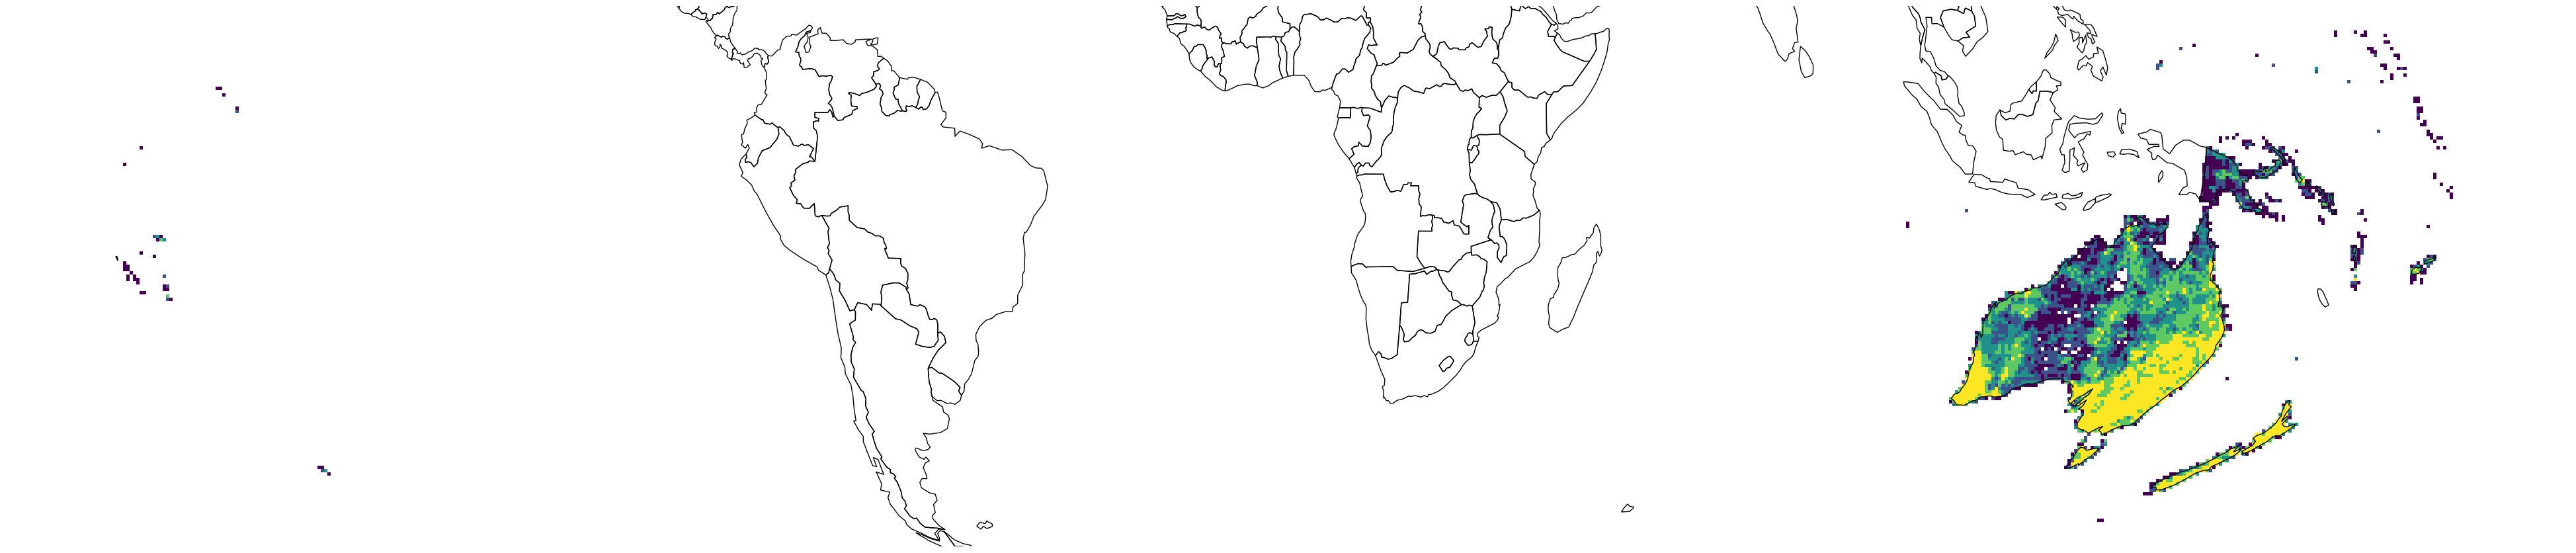

In [149]:
ax = cell_length.plot(column='road_density', figsize=(50, 40), scheme='quantiles', cmap='viridis')
plt.autoscale(False)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.to_crs(cell.crs).plot(ax=ax, color='none', edgecolor='black')
ax.axis('off')

In [150]:
cell_length.to_file('Oceania_50km_RoadDensity.gpkg')